In [ ]:
# 훈련하는 과정 동안 생성자는 훈련 데이터인 MNIST 손글씨 숫자 데이터셋 처럼 보이는 이미지를 만드는 방법을 학습 
# 동시에 판별자는 가짜 이미지를 훈련 데이터 셋에 있는 진짜 이미지와 구별하는 방법을 학습

In [ ]:
import matplotlib.pyplot as plt 
import numpy as np 

from tensorflow.keras.datasets import mnist 
from tensorflow.keras.layers import Dense, Flatten, Reshape , LeakyReLU
from tensorflow.keras.models import Sequential 
from tensorflow.keras.optimizers import Adam

In [ ]:
img_rows = 28 
img_cols = 28
channels = 1 

img_shape = (img_rows, img_cols, channels) 

z_dim = 100 # 생성자의 입력으로 사용될 z 벡터의 크기 

In [ ]:
# 생성자 구현 
# 출력층에 tanh를 사용한 이유 [=1, 1] 범위로 하여 sigmoid 보다 조금 더 또렷한 이미지를 만들기 때문 
def build_generator(img_shape, z_dim):
  model = Sequential()

  model.add(Dense(128, input_dim = z_dim)) 
  model.add(LeakyReLU(alpha = 0.01)) 
  model.add(Dense(28 * 28 * 1, activation = 'tanh'))
  model.add(Reshape(img_shape))
  return model

In [ ]:
# 판별자 구현 
# 28 x 28 x 1 크기의 이미지를 받아 가짜와 비교해 얼마나 진짜인지 나타내는 확률을 출력 
# 출력층에 sigmoid 이유 [0, 1] 범위로 판별자가 입력을 진짜로 생각하는 확률로 해석 
def build_discriminator(img_shape):
  model = Sequential()

  model.add(Flatten(input_shape = img_shape)) # 입력 이미지를 펼치기 
  model.add(Dense(128))
  model.add(LeakyReLU(alpha = 0.01))
  model.add(Dense(1, activation = 'sigmoid'))
  return model

In [ ]:
# 모델 생성 
# binary cross entropy : 두 개의 클래스만 있는 예측에서 계산된 확률과 진짜 확률 사이의 차이를 측정 

def build_gan(generator, discriminator):
  model = Sequential()

  # 생성자 + 판별자 모델 연결
  model.add(generator) 
  model.add(discriminator)

  return model 

# 판별자 모델 만들고 컴파일
discriminator = build_discriminator(img_shape) 
discriminator.compile(loss = 'binary_crossentropy',
                      optimizer = Adam(),
                      metrics = ['accuracy'])

# 생성자 모델 만들기 
generator = build_generator(img_shape, z_dim) 
discriminator.trainable = False # 생성자 훈련 할 때 판별자 훈련은 하지 않게 함 
gan = build_gan(generator, discriminator)

gan.compile(loss = 'binary_crossentropy', 
            optimizer = Adam())

In [ ]:
# 훈련 
# 랜덤한 MNIST 이미지의 미니배치를 진짜 샘플로 받고 랜덤한 잡음 벡터 Z로 부터 가짜 이미지의 미니배치 생성
# 생성자의 파라미터를 고정한 채로 판별자 네트워크 훈련
# 가짜 이미지의 미니배치를 생성 -> 판별자의 파라미터를 고정한 채로 생성자 네트워크 훈련 
# 위 과정 반복 

losses = []
accuracies = []
iteration_checkpoints = []

def train(iterations, batch_size, sample_interval):

  (X_train, _), (_, _) = mnist.load_data()

  X_train = X_train / 127.5 - 1.0 # -1 ~ 1 사이로 스케일 조절 -> 왜냐하면 생성자에서 활성화 함수를 tanh 로 썼기 때문
  X_train = np.expand_dims(X_train, axis=3)

  # 원핫 인코딩
  real = np.ones((batch_size , 1))
  fake = np.zeros((batch_size, 1))

  for iteration in range(iterations) :

    # 진짜 이미지에서 랜덤 배치 가져옴
    # random.randint : (최소값, 최대값, 개수) 
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    imgs = X_train[idx]

    # random.mormal : 정규 분포로부터 샘플링된 난수 반환
    z = np.random.normal(0, 1, (batch_size, 100)) # 가짜 이미지 배치 생성 N(0, 1) 부터 얻은 임의의 숫자 (batch_size, 100) 모양
    gen_imgs = generator.predict(z)
    d_loss_real = discriminator.train_on_batch(imgs, real)
    d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
    d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)

    z = np.random.normal(0, 1, (batch_size, 100))

    g_loss = gan.train_on_batch(z, real) # 생성자 훈련

    if (iteration + 1) % sample_interval == 0:
      losses.append((d_loss, g_loss))
      accuracies.append(100.0 * accuracy)
      iteration_checkpoints.append(iteration + 1)

      print("%d [D 손실 : %f, 정확도 : %.2f%%] [G 손실 : %f]" % (iteration + 1, d_loss, 100.0 * accuracy, g_loss))

      sample_images(generator)

In [ ]:
# 생성된 이미지 출력 
# 생성자가 합성한 4x4 이미지 그리드 출력 

def sample_images(generator, image_grid_rows = 4, image_grid_cols = 4):

  z = np.random.normal(0, 1, (image_grid_rows * image_grid_cols, z_dim))

  gen_imgs = generator.predict(z) # 랜덤한 잡음에서 이미지 생성 

  gen_imgs = 0.5 * gen_imgs + 0.5 # 이미지 픽셀 값을 0 ~ 1 범위로 조정 

  fig, axs = plt.subplots(image_grid_rows,
                          image_grid_cols,
                          figsize = (4,4),
                          sharey = True,
                          sharex = True)
  
  cnt = 0
  for i in range(image_grid_rows):
    for j in range(image_grid_cols):
      axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap = 'gray')
      axs[i, j].axis('off')
      cnt += 1

1000 [D 손실 : 0.295201, 정확도 : 87.50%] [G 손실 : 3.822360]
2000 [D 손실 : 0.313873, 정확도 : 88.67%] [G 손실 : 3.405048]
3000 [D 손실 : 0.152448, 정확도 : 93.75%] [G 손실 : 4.292979]
4000 [D 손실 : 0.179869, 정확도 : 94.14%] [G 손실 : 4.814365]
5000 [D 손실 : 0.263483, 정확도 : 89.45%] [G 손실 : 4.224154]
6000 [D 손실 : 0.294352, 정확도 : 88.67%] [G 손실 : 4.922885]
7000 [D 손실 : 0.230209, 정확도 : 89.45%] [G 손실 : 4.373930]
8000 [D 손실 : 0.524404, 정확도 : 79.30%] [G 손실 : 2.737720]
9000 [D 손실 : 0.347424, 정확도 : 84.77%] [G 손실 : 3.028628]
10000 [D 손실 : 0.342627, 정확도 : 85.55%] [G 손실 : 2.412911]
11000 [D 손실 : 0.380986, 정확도 : 85.16%] [G 손실 : 3.112688]
12000 [D 손실 : 0.301764, 정확도 : 86.33%] [G 손실 : 3.607053]
13000 [D 손실 : 0.218914, 정확도 : 91.02%] [G 손실 : 3.604675]
14000 [D 손실 : 0.441872, 정확도 : 81.25%] [G 손실 : 2.988291]
15000 [D 손실 : 0.348881, 정확도 : 84.38%] [G 손실 : 3.052734]
16000 [D 손실 : 0.446404, 정확도 : 78.52%] [G 손실 : 2.301149]
17000 [D 손실 : 0.262555, 정확도 : 87.11%] [G 손실 : 3.011768]
18000 [D 손실 : 0.308125, 정확도 : 87.89%] [G 손실 : 2.631535]
1

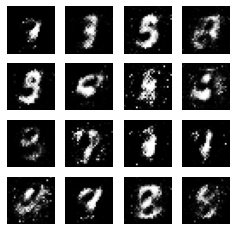

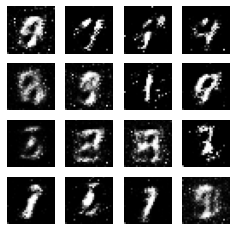

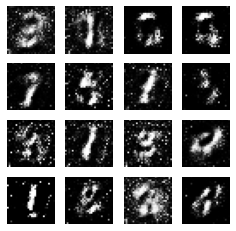

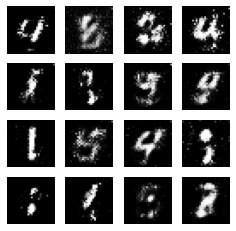

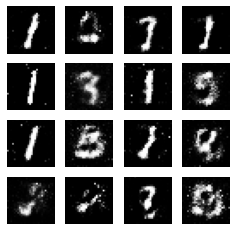

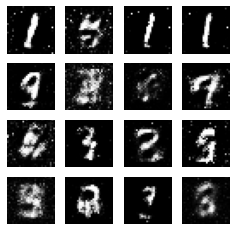

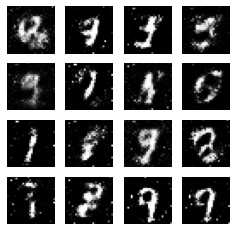

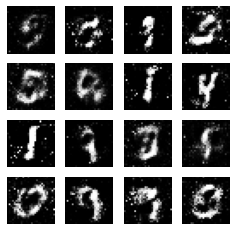

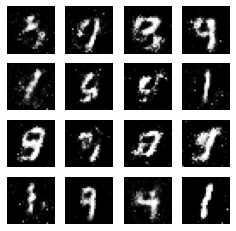

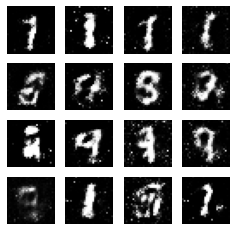

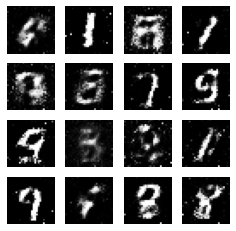

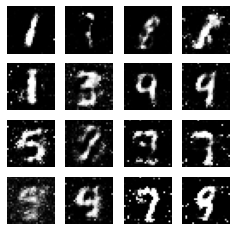

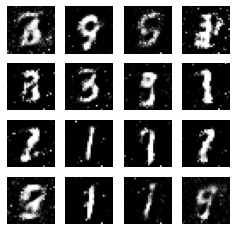

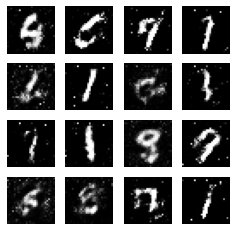

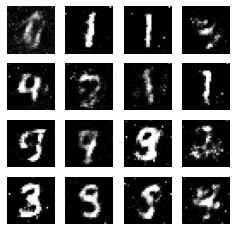

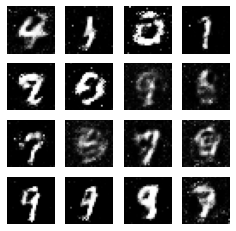

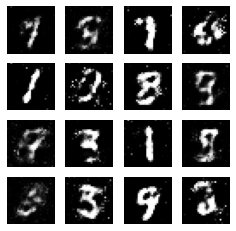

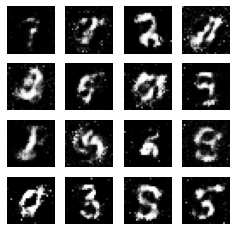

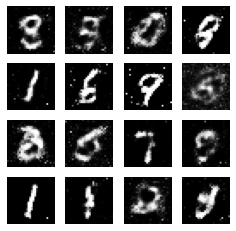

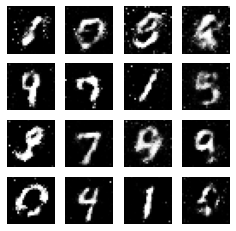

In [ ]:
iterations = 20000
batch_size = 128
sample_interval = 1000

train(iterations, batch_size, sample_interval)

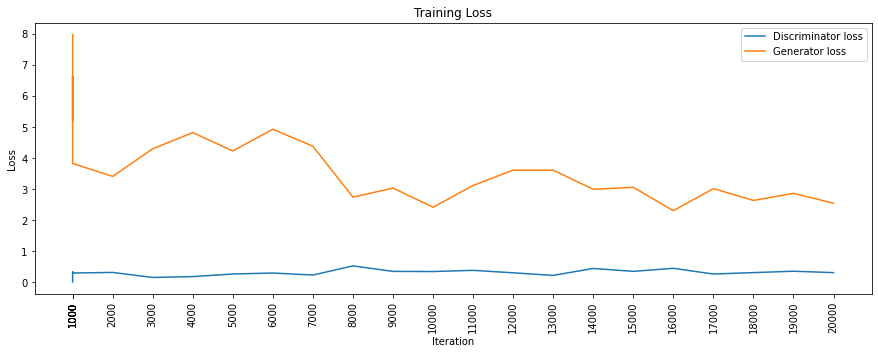

In [ ]:
losses = np.array(losses)

# 판별자와 생성자의 훈련 손실 그래프
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, losses.T[0], label="Discriminator loss")
plt.plot(iteration_checkpoints, losses.T[1], label="Generator loss")

plt.xticks(iteration_checkpoints, rotation=90)

plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

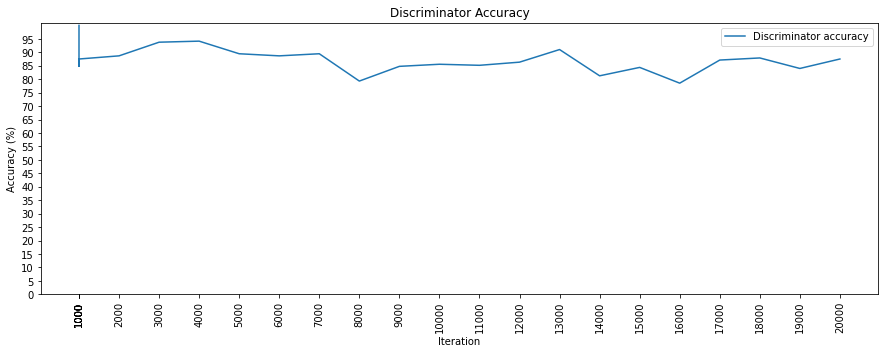

In [ ]:
accuracies = np.array(accuracies)

# 판별자의 정확도 그래프
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, accuracies, label="Discriminator accuracy")

plt.xticks(iteration_checkpoints, rotation=90)
plt.yticks(range(0, 100, 5))

plt.title("Discriminator Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy (%)")
plt.legend()